In [1]:
from queue import Queue
import networkx as nx
import matplotlib.pyplot as plt
from random import seed
from random import randint
from math import sin, cos, sqrt, pi

seed()

In [2]:
def show(nodes, edge_list, fig_sz = (5,5)):
    '''
    Displays graph.

    Parameters:
    -----------
    nodes : dict
        a dictionary, with node labels as keys, and node positions as values 
    '''
    # - TODO: set axes to be -1, 1 always
    G_drawable = nx.Graph()

    for node in nodes.keys():
        G_drawable.add_node(node)

    plt.figure(figsize = fig_sz)
    nx.draw_networkx_nodes(G_drawable, nodes, cmap = plt.get_cmap('jet'))
    nx.draw_networkx_edges(G_drawable, nodes, edge_list)
    nx.draw_networkx_labels(G_drawable, nodes)

In [3]:
# Graph generators.
def make_tree(layers, max_children_cnt = 2, randomize_child_count = False):
    queue = Queue()
    depth = {}
    vtx_idx = 1

    res = {f'{vtx_idx}': []}
    queue.put(f'{vtx_idx}')

    depth[f'{vtx_idx}'] = 1
    
    while not queue.empty():
        v = queue.get()

        new_vtx_depth = depth[v] + 1
        if new_vtx_depth > layers:
                continue 

        res.setdefault(v, [])

        child_count = max_children_cnt if not randomize_child_count else randint(1, max_children_cnt) 
        for _ in range(0, child_count):
            vtx_idx += 1
            queue.put(f'{vtx_idx}')
            depth[f'{vtx_idx}'] = new_vtx_depth

            res[v].append(f'{vtx_idx}')

    return res

In [4]:
# Dummy vertex, not present in the graph.
G_DUD_VTX = "#DUD#"

class DAG:
    adj_list = {}

    def __init__(self, adj_list):
        self.adj_list = adj_list

    def is_leaf(self, node):
        if node == G_DUD_VTX:
            return False
        return node not in self.adj_list.keys()
    
    def children_cnt(self, node):
        return 0 if node == G_DUD_VTX or self.is_leaf(node) else len(self.adj_list[node])

    def children(self, node):
        return [] if self.children_cnt(node) == 0 else self.adj_list[node]
    
    def edges(self):
        res = []
        for key in self.adj_list.keys():
            for child in self.children(key):
                res.append((key, child))

        return res

In [44]:
def rings_layout(graph: DAG, root_node, R1 : float = 1.0, min_vtx_to_place_per_step : int = 4):
    '''
    Implementation of the DAG layout algorithm from Teoh et. al. "RINGS: A Technique for Visualization of Large Hierarchies"

    Parameters
    ------
    graph                     : DAG
                                graph to layout
    root_node                 : Any
                                root node of the graph
    R1                        : float
                                radius of the largest ring.
    min_vtx_to_place_per_step : int
                                minimum amount of vertices to place in the outer ring.

    Returns
    ------
    A dictionary, where keys are node names and values are 2-element arrays, with x and y coordinates of the nodes.

    Discussion
    ------
    - TODO:
    '''
    # If it's 2 - _fraction_of_free_space will divide by zero.
    # If it's 1 - the outer ring will always have the same area as inner (bullshit).
    # 3 seems reasonable, because article contructs algorithm around polygons,
    # and intuitively polygon has to have at least 3 sides. 
    min_vtx_to_place_per_step = max(min_vtx_to_place_per_step, 3)

    def _fraction_of_free_space(outer_nodes_cnt: int):
        '''
        Computes quoutient of outer and inner circle areas.

        Parameters:
        ------
        outer_nodes_count : int
                            number of nodes in the outer ring. Should be at least 3.
        '''
        return (1 - sin(pi / outer_nodes_cnt))**2 / ((1 + sin(pi / outer_nodes_cnt))**2)

    def _stop_criteria(outer_nodes, total_grand_children: float):
        '''
        Computes predicate, used to decide 'minimum k'.

        Parameters:
        ------
        outer_nodes : list
                      number of children we consider placing in the outer ring  
        '''

        nonlocal min_vtx_to_place_per_step
        if len(outer_nodes) < min_vtx_to_place_per_step:
            return False

        # count total number of children, of the outer_nodes (grand children of the root).
        grandchildren = sum(list(map(lambda x: graph.children_cnt(x), outer_nodes)))
        return grandchildren / total_grand_children >= _fraction_of_free_space(len(outer_nodes))
    
    def _sort_children_by_gchildren_count(graph: DAG, children):
        '''
        Sort nodes by the number of their children

        Parameters:
        ------
        graph : DAG
                graph object.
        children: list
                nodes to sort.
        '''

        children_cnt = []

        for child in children:
            children_cnt.append(graph.children_cnt(child))

        zipped = list(zip(children, children_cnt))
        return list(map(lambda x: x[0], sorted(zipped, key = lambda x: -x[1])))
    
    def _count_grand_children(graph: DAG, children):
        '''
        Count total number of children of the given list of nodes.

        Parameters:
        ------
        graph : DAG
                graph object
        children : list
                    nodes to count total number of children for.
        '''
        return sum(list(map(lambda x: graph.children_cnt(x), children)))

    q = Queue()
    q.put((root_node, (0, 0), R1, graph.children(root_node)))

    pos = { root_node : [0, 0] }
    while not q.empty():
        curr_root, par_center, r1, children = q.get()

        # Base case.
        # All children are leafs. Just put them around root.
        if len(list(filter(lambda x: not graph.is_leaf(x), children))) == 0:
            r1 /= 2
            angle = 2*pi / len(children)

            for idx, node in enumerate(children):
                # - TODO: set intial angle, rotating by depth.
                node_coordinates = (par_center[0] + r1*cos(idx * angle), par_center[1] + r1*sin(idx * angle))
                pos[node] = [node_coordinates[0], node_coordinates[1]]

            continue

        if len(children) == 0:
            raise Exception(f'{curr_root} has no children left to place.')

        # Sort children of the current root, byt the number of their children.
        sorted_children = _sort_children_by_gchildren_count(graph, children)
        total_grand_children = _count_grand_children(graph, children)

        # If node has only leafs, total grand children will be zero.
        total_grand_children = max(total_grand_children, 1)

        # Nodes, to place in the outer ring.
        outer_nodes = []

        # Nodes, to place in the inner ring
        inner_nodes = []

        # All nodes go into inner ring, unless...
        inner_nodes.extend(sorted_children)
        idx = 0

        # ...they go into outer ring, because we believe we can place at least min_vtx_to_place_per_step nodes there.  
        while idx < len(sorted_children):
            if graph.is_leaf(sorted_children[idx]):
                break

            if len(outer_nodes) >= min_vtx_to_place_per_step and _stop_criteria(outer_nodes, total_grand_children):
                break
            
            outer_nodes.append(sorted_children[idx])
            idx += 1

        # Remove outer from inner.
        inner_nodes = sorted_children[idx : len(sorted_children)+1]

        # Add placeholder vertices, to avoid breaking math in _fraction_of_free_space.
        while idx < min_vtx_to_place_per_step:
            outer_nodes.append(G_DUD_VTX)
            idx += 1

        # Step angle to place outer vertices.
        angle = 2*pi / len(outer_nodes)

        # Radius of the ring, where inner vertices should go.
        r2 = r1*sqrt(_fraction_of_free_space(len(outer_nodes)))

        # Shouldn't happen.
        if r2 > r1:
            raise Exception(f'R2 = {r2} cannot be bigger than R1 = {r1}')
        
        # For current root's grand children, this will be the new R1 (see image in article.)
        new_r1_outer_node = (r1 - r2) / 2

        # Radius, to place outer vertices.
        rad_for_coords = r2 + new_r1_outer_node 

        for idx, node in enumerate(outer_nodes):
            # Compute polar for outer.
            # - TODO: set intial angle, rotating by depth.
            node_coordinates = (par_center[0] + rad_for_coords*cos(idx * angle), par_center[1] + rad_for_coords*sin(idx * angle))

            # Don't save placeholder vertices into result.
            if node != G_DUD_VTX:
                pos[node] = [node_coordinates[0], node_coordinates[1]]

                # If it's a leaf, we placed it, and we are done. If not
                # we need to recursively place all its children.
                if not graph.is_leaf(node):
                    q.put((node, node_coordinates, new_r1_outer_node, graph.children(node)))

        # For inner nodes of the root, this will be new R1.
        new_r1_inner_node = r2

        # If there are inner nodes left we need to place them, recursively.
        # The difference from the recursive case above is the root of these nodes,
        # along with geometrical information.
        if len(inner_nodes) != 0:
            q.put((curr_root, par_center, new_r1_inner_node, inner_nodes))

    return pos
        

In [51]:
adj_list = make_tree(3, max_children_cnt=5)
adj_list['1'].append('A')
adj_list['1'].append('B')
adj_list['1'].append('C')
adj_list['1'].append('D')
q_tree = DAG(adj_list)

pos = rings_layout(q_tree, '1')

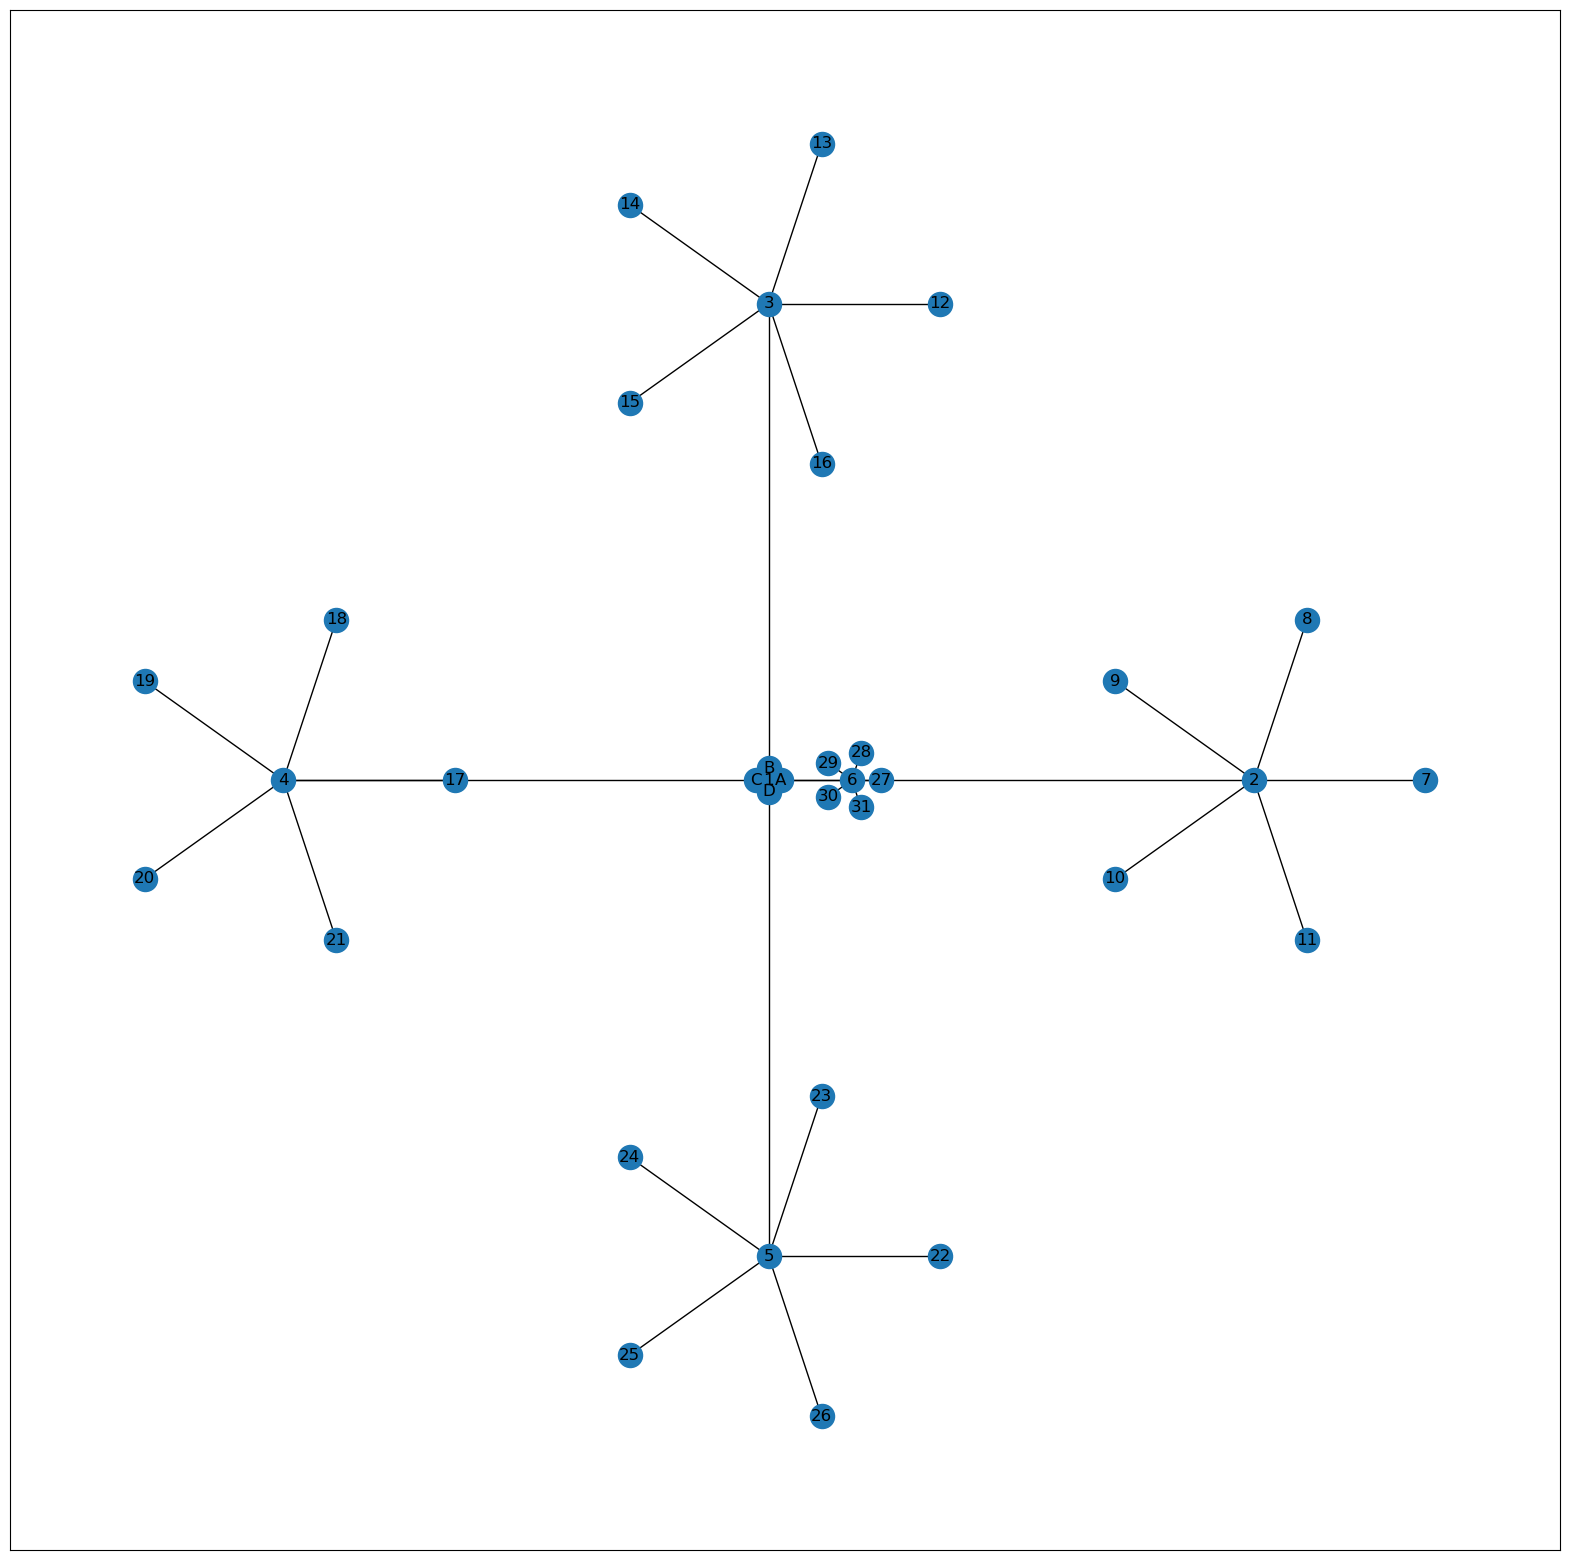

In [54]:
show(pos, q_tree.edges(), fig_sz=(20,20))